# Pytorch with Tensorboard

It is one of the toolkit which provides the visualization and tooling needed for machine learning experimentation.

following are the advantages of TensorBoard :

* Tracking and visualizing matrics such as loss and accuracy
* Visualizing the model graph (ops and layers)
* Viewing histograms of weights,biases or other tensors as they change over time
* Projecting embeddings to a lower dimensional space
* Displaying images,text and audio data
* Profiling Tensorflow programs


Lets visualize the plots and charts of training the Fashion Mnist dataset using `LeNet-5`

### Importing Tensorboard

In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np



from torch.utils.tensorboard import SummaryWriter

### Visualizing Dataset in Tensorboard

lets prepare our data. we will convert our data to tensor and then normalize it

In [90]:
# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms

In [91]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize( (0.5,),(0.5,) )
    ]
)

### Getting Data and initiating data loader

In [92]:
# Store separate training and validations splits in ./data
training_set = torchvision.datasets.FashionMNIST('../data',
    download=True,
    train=True,
    transform=transform)

validation_set = torchvision.datasets.FashionMNIST('../data',
    download=True,
    train=False,
    transform=transform)

training_loader = torch.utils.data.DataLoader(training_set,
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=2)


validation_loader = torch.utils.data.DataLoader(validation_set,
                                                batch_size=4,
                                                shuffle=False,
                                                num_workers=2)

Our data is labeled in integers. So lets create a tuple of string corresponding to the class labels

In [93]:
# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [94]:
# Extract a batch of 4 images
dataiter = iter(training_loader)
images, labels = next(dataiter)

In the above code, we obtained images and labels with batch size of 4


The function iter() and next() can be understood from the image below ;

![image](./image/iter.jpg)

Lets visualize them using Matplotlib

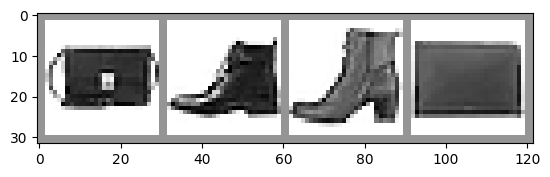

In [95]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

Now instead of using matplotlib , lets visualize it using `Tensorboard`.

In [96]:
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

# Writing  image data to TensorBoard log dir
writer.add_image('Four Fashion-MNIST Images', img_grid)
writer.flush()

To open the tensorboard host

```bash
$ tensorboard --logir=runs
```

![tensorboard_image](./image/tensorboard_image.png)

### Graphing Scalars to Visualize Training

Lets track the training metrics in `tensorboard`

Below is a deep convolution neural network which will  be used to classify the image data

In [103]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = LeNet()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Now training

In [101]:
for epoch in range(1):
    running_loss = 0
    print("Epoch {}".format(epoch))
    for i,data in enumerate(training_loader,0):
        inputs,labels = data # batch of 4
        optimizer.zero_grad() # resetting previous gradients to zero
        outputs = model(inputs) 
        loss = loss_func(outputs,labels)
        loss.backward() # Compute gradient
        optimizer.step() # update the parameters through calculated weights

        running_loss += loss.item() # loss.item() contains the loss of entire of mini-batch, but divided by the batch size


        # finding validation loss every 100 iteration for a epoch

        if i % 100 == 99 :
            print("Batch {}".format(i+1))

            running_vloss = 0
            # Since we are doing evaluation only we dont want to update the weights of the network. So,
            model.train(False)

            # lets find the running loss of the validation data
            for j, validation_data in enumerate(validation_loader,0):
                vinputs , vlabels = validation_data
                voutputs = model(vinputs)
                vloss = loss_func(voutputs, vlabels)
                running_vloss += vloss.item()
            
            # we have found both validation running loss and training loss. So lets write these data to tensorboard

            avg_training_loss = running_loss / 100
            avg_vloss = running_vloss / len(validation_loader)

            writer.add_scalars( 'Training and Validation Loss' , 
                {  'Training' : avg_training_loss , 'Validation ' : avg_vloss  },
                epoch * len(training_loader) + i )

            running_loss = 0.0

        if i == 1000 :
            break

    print("Training Finished")
    writer.flush()


Epoch 0
Batch 100
Batch 200
Batch 300
Batch 400
Batch 500
Batch 600
Batch 700
Batch 800
Batch 900
Batch 1000
Training Finished


![tensorboard_logs](./image/tensorboard_training.png)

### Visualizing dataset with embeddings

When we pass the data into a simpler network , they will be flattened out. So if we want to visualize data into 3D axis with highest variance.

To do this, we use `add_embedding()` method which displays a interactive 3D chart.

`torch.randperm`

Returns a random permutation of integers from 0 to n - 1.

In [ ]:
# Select a random subset of data and corresponding labels
def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# Extract a random subset of data
images, labels = select_n_random(training_set.data, training_set.targets)

# get the class labels for each image
class_labels = [classes[label] for label in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.flush()
writer.close()

![tensorflow_visualization](./image/dataset_visualization.png)

### Inspecting the model using Tensorboard

In [105]:
writer.add_graph(model, images)
writer.close

<bound method SummaryWriter.close of <torch.utils.tensorboard.writer.SummaryWriter object at 0x730e547bed70>>

![model_visualization](./image/model_visualization.png)